## Importações e dependências

In [1]:
import os
import glob
import cv2
import numpy as np
import hashlib
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.image import ImageDataGenerator
from collections import Counter

print("Importações e dependencias feitas com sucesso")

Importações e dependencias feitas com sucesso


## Caminhos

In [2]:
# Diretório onde as imagens do dataset se encontram armazenadas

#data_train = '/Users/hugopereira/DatasetMEIA/train'
#data_test = '/Users/hugopereira/DatasetMEIA/test'

data_train = 'C:/Dev/DatasetMEIA/train'
data_test = 'C:/Dev/DatasetMEIA/test'

if os.path.exists(data_train) and os.path.exists(data_test):
    print("As pastas de dados existem e estão acessíveis.")
else:
    if not os.path.exists(data_train):
        print(f"A pasta de treino '{data_train}' não existe ou não está acessível.")
    if not os.path.exists(data_test):
        print(f"A pasta de teste '{data_test}' não existe ou não está acessível.")

As pastas de dados existem e estão acessíveis.


## Importar Imagens 
Importação de imagens do conjunto teste e treino para efetuar o seu processamento. Ao importar a imagem é tambem guardado o nome a ela associado e é criada uma hash para posteriormente verificar se existem imagens duplicadas.


In [ ]:
#Função para calcular uma hash para cada imagem
def calculate_hash(img):
    return hashlib.sha256(img).hexdigest()

# Função para carregar imagens de uma dada pasta
def load_images_from_folder(folder):
    images = []
    hashes=[]
    path=[]
    images_by_class={}
    #Considera todas as pastas dentro do diretorio em que se encontra
    disease_folder=glob.glob(os.path.join(folder, "*"))
    for files in disease_folder:
        print(f"A carregar imagens... {files}")
        for filename in os.listdir(files):
            try:
                img = cv2.imread(os.path.join(files, filename),cv2.IMREAD_UNCHANGED)
                if img is not None:
                    images.append(img)
                    path.append(filename)
                    hash_imagem=calculate_hash(img)
                    hashes.append(hash_imagem)
                else:
                    print(f"Não foi possível carregar a imagem: {filename}")
            except Exception as e:
                    print(f"Erro ao carregar a imagem {filename}: {str(e)}")           
    return images, hashes, path, images_by_class

# Carregar imagens de treino e teste
train_images, train_hashes, train_names, train_images_by_class = load_images_from_folder(data_train)
test_images, test_hashes, test_names, test_images_by_class = load_images_from_folder(data_test)

# Verificar se as imagens foram carregadas corretamente
print(f"Número de imagens de treino carregadas: {len(train_images)}")
print(f"Número de imagens de teste carregadas: {len(test_images)}")

# Imprimir o número e nomes dos arquivos por classe nos dados de treino
print("Imagens de treino por classe:")
for class_label in set(train_labels):
    class_filenames = [filename for filename, label in zip(train_filenames, train_labels) if label == class_label]
    print(f"Classe: {class_label}, Número de imagens: {len(class_filenames)}")
    print()

# Imprimir o número e nomes dos arquivos por classe nos dados de teste
print("Imagens de teste por classe:")
for class_label in set(test_labels):
    class_filenames = [filename for filename, label in zip(test_filenames, test_labels) if label == class_label]
    print(f"Classe: {class_label}, Número de imagens: {len(class_filenames)}")
    print()

A carregar imagens... C:/Dev/DatasetMEIA/train\Atopic Dermatitis Photos
A carregar imagens... C:/Dev/DatasetMEIA/train\Lupus and other Connective Tissue diseases
A carregar imagens... C:/Dev/DatasetMEIA/train\Melanoma Skin Cancer Nevi and Moles
A carregar imagens... C:/Dev/DatasetMEIA/train\Psoriasis pictures Lichen Planus and related diseases


## Visualização das Imagens

In [4]:
#Função para ver as imagens lado a lado
def see_array_plt(images, images_title=None):
    num_images = len(images)
    if images_title is None:
        images_title = [f"Image {i+1}" for i in range(num_images)]
        
    num_rows = (num_images - 1) // 3 + 1
    plt.figure(figsize=(20, 6 * num_rows))
    for num in range(num_images):
        plt.subplot(num_rows, 3, num + 1)
        plt.axis(False)
        plt.title(f"{images_title[num]}.")
        plt.imshow(images[num]);

Visualização de algumas imagens de treino


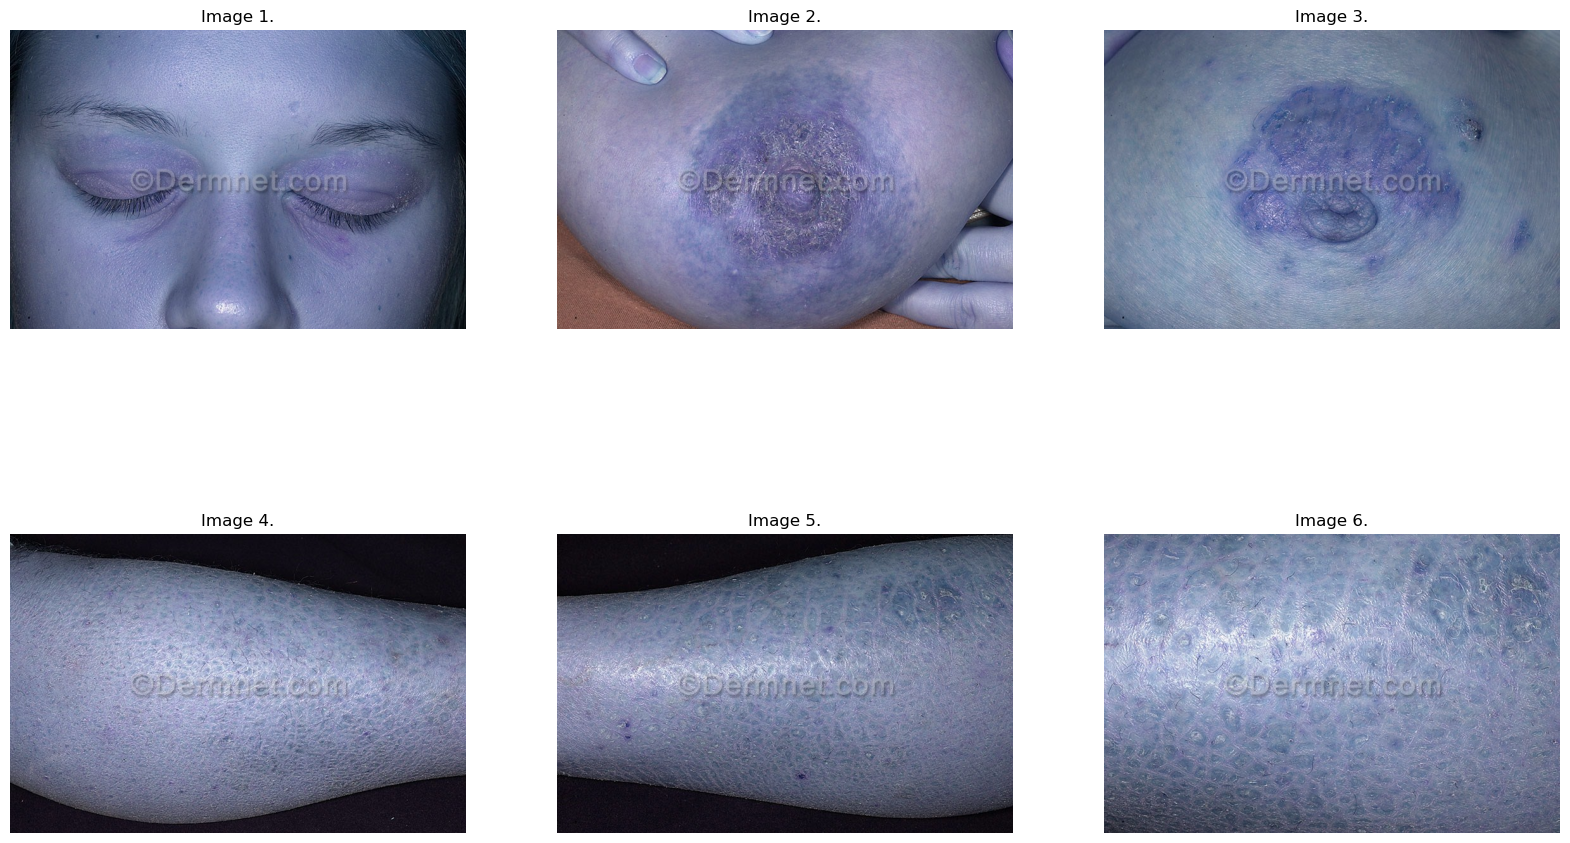

-------------------------------------------------
Visualização de algumas imagens de teste


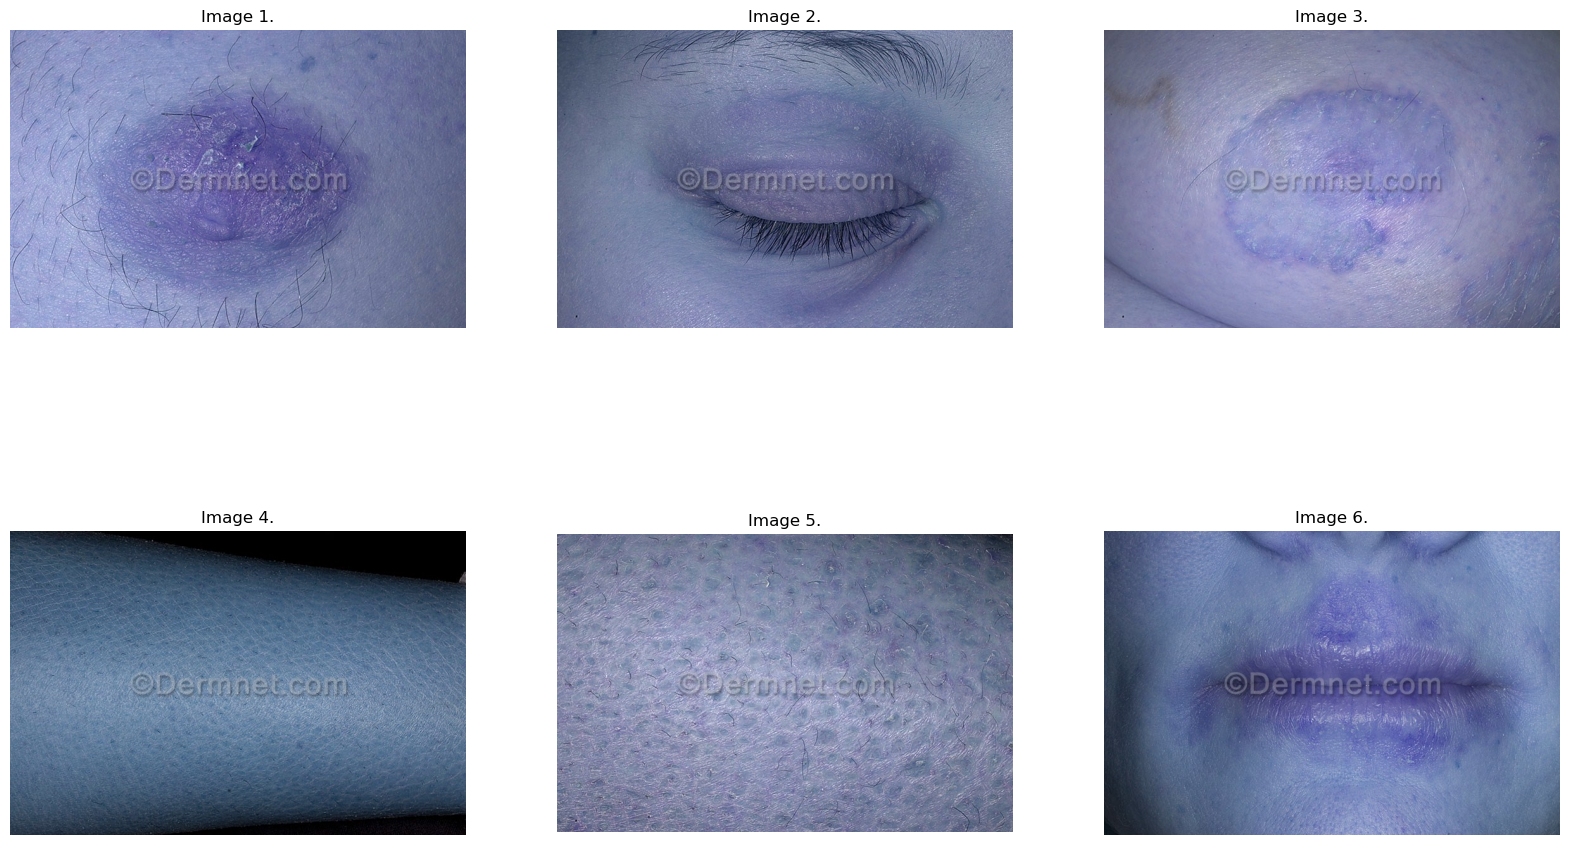

In [5]:
max_images = 6  # Define o número máximo de imagens a serem mostradas
print("Visualização de algumas imagens de treino")
see_array_plt(train_images[:max_images])
plt.show()  # Garante que as imagens de treino sejam exibidas antes do próximo print
print("-------------------------------------------------")
print("Visualização de algumas imagens de teste")
see_array_plt(test_images[:max_images])
plt.show()  # Garante que as imagens de treino sejam exibidas antes do próximo print

# Pré-processamento

# 1.2 Redimensionar Imagens
Para ambos os conjuntos(treino e teste) o tamanho das imagens é ajustado, cortando a imagem caso esta seja maior que o tamanho pretendido(224x224) ou então aumentada atraves de uma borda.

In [6]:
# Redimensionar imagens
def resize_images(images, new_size):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, new_size)
        resized_images.append(resized_img)
    return resized_images

# Tamanho desejado para as imagens (250x250)
new_size = (250, 250)

# Redimensionar imagens de treino e teste
train_images_resized = resize_images(train_images, new_size)
test_images_resized = resize_images(test_images, new_size)

# Verificar se as imagens foram redimensionadas corretamente
print(f"Número de imagens de treino redimensionadas: {len(train_images_resized)}")
print(f"Número de imagens de teste redimensionadas: {len(test_images_resized)}")

Número de imagens de treino redimensionadas: 2989
Número de imagens de teste redimensionadas: 749


## 1.8 Normalização e Balanceamento dos dados

Para balancear as classes existentes implementamos o Random Over Sampler, este aumenta artificialmente o número de exemplos nas classes minoritárias.

In [7]:
def normalize_images(images):
    normalized_images = []
    for img in images:
        normalized_img = img / 255.0  # Normalizar os valores dos pixels para o intervalo [0, 1]
        normalized_images.append(normalized_img)
    return np.array(normalized_images)

# Normalizar imagens de treinamento e teste
train_images_normalized = normalize_images(train_images_resized)
print(f"Imagens do treino normalizadas concluídas...")

test_images_normalized = normalize_images(test_images_resized)
print(f"Imagens do teste normalizadas concluídas...")

Imagens do treino normalizadas concluídas...
Imagens do teste normalizadas concluídas...


Contagem de amostras por classe após oversampling e normalização:
{'Atopic Dermatitis Photos': 1405, 'Lupus and other Connective Tissue diseases': 1405, 'Melanoma Skin Cancer Nevi and Moles': 1405, 'Psoriasis pictures Lichen Planus and related diseases': 1405, 'Urticaria Hives': 1405}


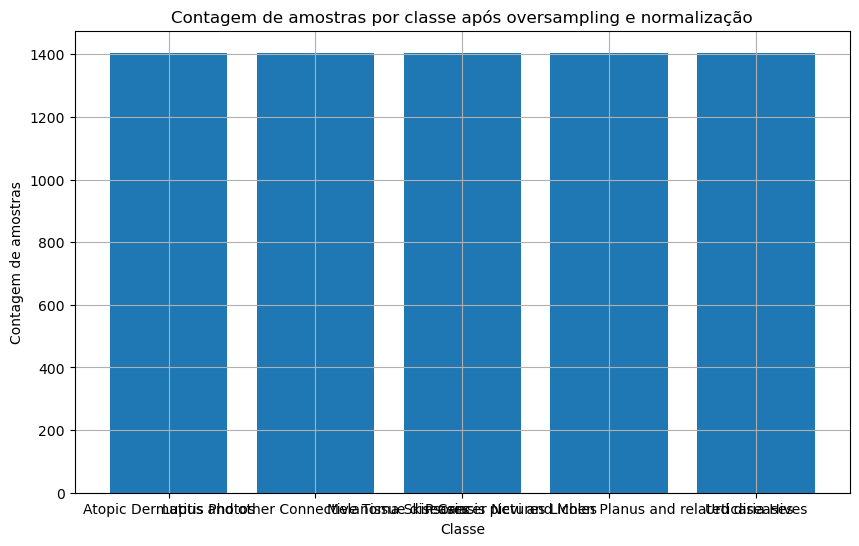

In [8]:
#Guarda em labels, os nomes das pastas que se encontram dentro da pasta fornecida
def assign_labels_from_folders(images_folder):
    labels = []
    for folder_name in os.listdir(images_folder):
        folder_path = os.path.join(images_folder, folder_name)
        if os.path.isdir(folder_path):
            for image_name in os.listdir(folder_path):
                labels.append(folder_name)
    return labels

# Atribuir labels às imagens de treinamento e teste com base nas pastas que se encontram dentro destas
train_labels = assign_labels_from_folders(data_train)
test_labels = assign_labels_from_folders(data_test)

# Ajustar os labels para corresponder ao número de imagens normalizadas
train_labels = train_labels[:len(train_images_normalized)]
#print("Tamanho das imagens normalizadas: ",len(train_images_normalized))
#print("Tamanho dos train_labels tendo em conta as imagens normalizadas: ",train_labels)
#print("SET TRAIN LABELS: ", set(train_labels))

# Verificar se o número de labels unicas corresponde ao número de imagens normalizadas
if len(set(train_labels)) != 5:
    print("O número de labels não corresponde ao número esperado de classes.")

# Realizar oversampling apenas nas classes minoritárias após a normalização
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(train_images_normalized.reshape(train_images_normalized.shape[0], -1), train_labels)

# Verificação do balanceamento após oversampling
unique_resampled, counts_resampled = np.unique(y_train_resampled, return_counts=True)
class_counts_resampled = dict(zip(unique_resampled, counts_resampled))

print("Contagem de amostras por classe após oversampling e normalização:")
print(class_counts_resampled)

# Plotar um gráfico de barras para visualizar as contagens de cada classe
plt.figure(figsize=(10, 6))
plt.bar(class_counts_resampled.keys(), class_counts_resampled.values())
plt.xlabel('Classe')
plt.ylabel('Contagem de amostras')
plt.title('Contagem de amostras por classe após oversampling e normalização')
plt.xticks(list(class_counts_resampled.keys()))
plt.grid(True)
plt.show()

# Guardar os novos dados
Após o pre-processamento estar concluido guardar a nova instancia dos dados para posteriormente utiliza-los para treinar diferentes modelos

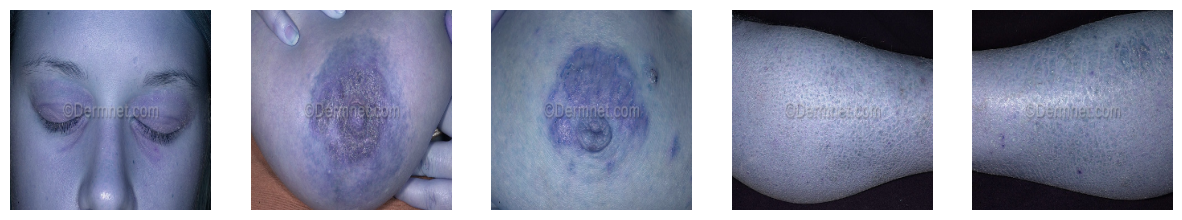

In [9]:
# Visualizar algumas imagens de treino após o pré-processamento
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train_resampled[i].reshape(250, 250, 3))  # Se a imagem estiver em escala de cinza, pode ser necessário remover o reshape
    ax.axis('off')
plt.show()

In [ ]:
# Função para salvar as imagens corretamente em pastas separadas por labels
def save_images_with_labels(images, labels, folder_path):
    unique_labels = set(labels)
    for label in unique_labels:
        label_folder = os.path.join(folder_path, label)
        os.makedirs(label_folder, exist_ok=True)  # Cria a pasta da label se ainda não existir
        label_indices = [i for i, l in enumerate(labels) if l == label]
        label_images = [images[i] for i in label_indices]  # Corrigindo a obtenção das imagens
        print(f"Label: {label}, Número de imagens: {len(label_images)}")
        for i, img in enumerate(label_images):
            img_uint8 = (img * 255).astype(np.uint8)
            cv2.imwrite(os.path.join(label_folder, f"image_{i}.jpg"), img_uint8)

# Caminhos das pastas de treino e teste
#train_folder_preprocessed = '/Users/hugopereira/Github/Left4Health_3rdProject/ClassificationOfSkinDiseases/preprocessed/train'
#test_folder_preprocessed = '/Users/hugopereira/Github/Left4Health_3rdProject/ClassificationOfSkinDiseases/preprocessed/test'
train_folder_preprocessed = 'DataProcessed/train'
test_folder_preprocessed = 'DataProcessed/test'

# Remover duplicatas nos rótulos de teste
test_images_unique = []
test_labels_unique = []
for i, label in enumerate(test_labels):
    if label not in test_labels_unique:
        test_labels_unique.append(label)
        test_images_unique.append(test_images_normalized[i])

# Salvar imagens de treino
save_images_with_labels(X_train_resampled.reshape(-1, 250, 250, 3), train_labels, train_folder_preprocessed)

# Salvar imagens de teste
save_images_with_labels(test_images_unique, test_labels_unique, test_folder_preprocessed)